# Chapter 5 深度神经网络-找出可能流失的客户

* 数据类型：
    * 结构化数据：有预先定义好的结构
    * 非结构化数据：没有什么预定义的数据结构，不方便用数据库存储，也不方便用Excel表格来表现的数据。
    
    
比如判断哪张照片属于什么类型就是非结构数据（也称感知类数据，人脑可以毫不费力的识别，但是计算机不行）\
**维度灾难**：高维度带来了超高的复杂度和超巨大的特征空间。\
神经网络的原理和线性回归或者逻辑回归相同---通过不断训练找出最佳参数！

***深度学习机理***： 用一串一串函数（层）不断堆叠起来，作用于输入数据，进行从原始数据到分类结果的过滤和提纯。

学习：就是为了神经网络的每一个层中的每个神经元寻找最佳的权重。


知识：学到的权重。
    

## 5.3 从感知器到单隐层网络

**Sigmoid函数**在逻辑回归中叫逻辑函数，在神经网络中则成为激活函数，用以类比人类神经系统中神经元的‘激活’过程。

* 输入空间：x
* 输出空间：y, actually y is less than x
* 特征空间： 每一个样本被称作一个实例，通常由特征向量表示，所有特征向量存在的空间被称为***特征空间***。 特征空间有时与输入空间相同，有时不同。因为有时候经过特征工程之后，输入空间可通过某种映射生成新的特征空间。
* 假设空间：一般是对学习到的模型（函数）而言的。模型表达了输入到输出的一种映射集合，这个集合就是假设空间。假设空间代表着模型学习过程中能够覆盖的最大范围。


**神经网络的上下标符号规则**：$w_{2.2}^{[1]}$中，*上*标的数字代表第几层，*下*标的数字有两个，第一个代表权重属于哪一个特征，即特征的维度；第二个代表其所连接到的下层神经元的维度。

## 5.4 用Keras单隐层网络预测客户流失率

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_bank=pd.read_csv('BankCustomer.csv')
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Female,40,Beijing,9,2,0,1,516,6360.66,0.0000,0
1,Xue Baochai,Male,69,Beijing,6,2,0,1,682,28605.00,0.0000,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1


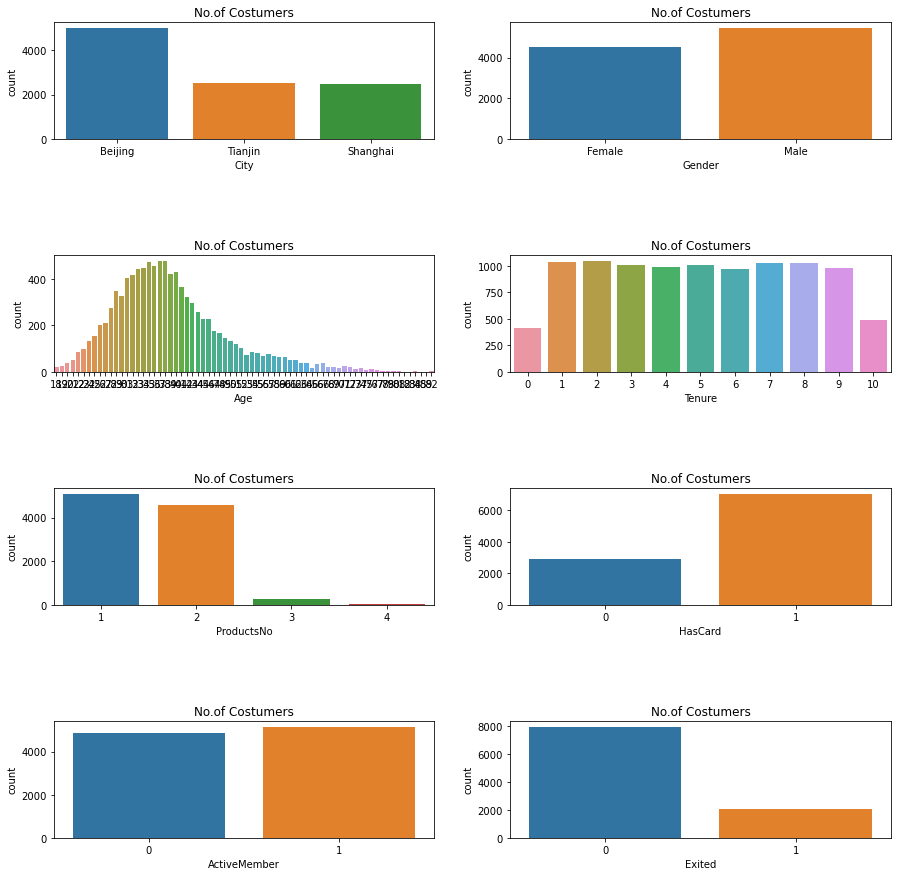

In [12]:
features=['City','Gender','Age','Tenure','ProductsNo','HasCard','ActiveMember','Exited']
fig=plt.subplots(figsize=(15,15))
for i,j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace=1.0)
    sns.countplot(x=j,data = df_bank)
    plt.title('No.of Costumers')
#这里我之前犯错了了，feature内部的名字，比如ProductsNo中间不要有空格，有空格就会报错！

从图中可以看出有三个需要从三个方向上来cleaning data:
    
    
* 性别：female 和male编程0/1代码，因为这属于’格式数据‘，在机器学习中需要转换成数字代码
* 城市：是多元类别特征，需要转换为多个二元类别哑变量
* 姓名与我们分析的问题无关，忽略掉。


In [14]:
df_bank['Gender'].replace('Female',0,inplace=True)
df_bank['Gender'].replace('Male',1,inplace=True)
print('Gender unique values',df_bank['Gender'].unique())

Gender unique values [0 1]


In [15]:
#对城市方面做data cleaning:转二元变量，然后再放回原始数据集
d_city=pd.get_dummies(df_bank['City'],prefix='City')
df_bank=[df_bank,d_city]#put bank to the data
df_bank=pd.concat(df_bank,axis=1)#axis=1表示横向对齐。
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited,City_Beijing,City_Shanghai,City_Tianjin
0,Kan Jian,0,40,Beijing,9,2,0,1,516,6360.66,0.0000,0,1,0,0
1,Xue Baochai,1,69,Beijing,6,2,0,1,682,28605.00,0.0000,0,1,0,0
2,Mao Xi,0,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1,1,0,0
3,Zheng Nengliang,0,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1,0,0,1
4,Zhi Fen,1,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1,0,0,1


关于pd.concat（数据的合并与重塑）见这里：[pd.concat中问](https://blog.csdn.net/stevenkwong/article/details/52528616),非常好的中文说明！

In [17]:
#构建特征和数据标签。
y=df_bank['Exited']
X=df_bank.drop(['Name','Exited','City'],axis=1)
X.head()
#数据标签一共有12个维度

,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,0,40,9,2,0,1,516,6360.66,0.0000,1,0,0
1,1,69,6,2,0,1,682,28605.00,0.0000,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311.0932,1,0,0
3,0,37,0,2,1,1,778,25564.01,129909.8079,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976.1948,0,0,1


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
#尝试先用Sklearn逻辑回归算法看一下：
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
history=lr.fit(X_train,y_train)
print('逻辑回归的预测准确率为：{:.2f}%'.format(lr.score(X_test,y_test)*100))

逻辑回归的预测准确率为：78.35%


In [20]:
#使用Keras package 构建sequence网络
import keras 
from keras.models import Sequential
from keras.layers import Dense
ann=Sequential()#构建一个Sequential ann模型
ann.add(Dense(units=12,input_dim=11,activation='relu'))#添加输入层
ann.add(Dense(units=24,activation='relu'))
ann.add(Dense(units=1,activation='sigmoid'))
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


***Sequential***也叫顺序模型，是最常用的深度网络层和层间结构，也就是一层接一层，顺序地堆叠。

***Dense***是最常用的深度网络层的类型，也称为全连接层，即当前层和其下一层的所有神经元之间全有连接。

In [23]:
#显示出神经网络形状的另一种方法：
from Ipython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG((model_to_dot(ann,show_shape=True).create(prog='dot',format='svg')))

ModuleNotFoundError: No module named 'Ipython'

In [25]:
#编译神经网络，指定优化器，损失函数，以及评估指标
ann.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])